<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_5_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 6: Convolutional Neural Networks (CNN) for Computer Vision**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 6 Material

* Part 6.1: Image Processing in Python [[Video]](https://www.youtube.com/watch?v=V-IUrfTJMm4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_1_python_images.ipynb)
* Part 6.2: Using Convolutional Neural Networks [[Video]](https://www.youtube.com/watch?v=nU_T2PPigUQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_2_cnn.ipynb)
* Part 6.3: Using Pretrained Neural Networks with Keras [[Video]](https://www.youtube.com/watch?v=TXqI9fp0imI&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_3_resnet.ipynb)
* Part 6.4: Looking at Keras Generators and Image Augmentation [[Video]](https://www.youtube.com/watch?v=epfpxiXRL3U&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_4_keras_images.ipynb)
* **Part 6.5: Recognizing Multiple Images with YOLOv5** [[Video]](https://www.youtube.com/watch?v=zwEmzElquHw&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_5_yolo.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [1]:
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


# Part 6.5: Recognizing Multiple Images with YOLO5

Programmers typically design convolutional neural networks to classify a single item centered in an image.  However, we can recognize many items in our field of view in real-time as humans.  It is advantageous to recognize multiple items in a single image.  One of the most advanced means of doing this is YOLOv5. You Only Look Once (YOLO) was introduced by Joseph Redmon, who supported YOLO up through V3. [[Cite:redmon2016you]](https://arxiv.org/abs/1506.02640) The fact that YOLO must only look once speaks to the efficiency of the algorithm.  In this context, to "look" means to perform one scan over the image. Figure 6.YOLO shows YOLO tagging in action.  It is also possible to run YOLO on live video streams.

 
Joseph Redmon left computer vision to pursue other interests. The current version, YOLOv5 is supported by the startup company [Ultralytics](https://ultralytics.com/), who released the open source library that we use in this class.[[Cite:zhu2021tph]](https://arxiv.org/abs/2108.11539)

Researchers have trained YOLO on a variety of different computer image datasets.  The version of YOLO weights used in this course is from the dataset Common Objects in Context (COCO). [[Cite: lin2014microsoft]](https://arxiv.org/abs/1405.0312) This dataset contains images labeled into 80 different classes.  COCO is the source of the file coco.txt that is used in this module.

**Figure 6.YOLO: YOLO Tagging**

![DarkNet](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/darknet-predictions.jpg "DarkNet")

### Using YOLO in Python

To make use of YOLO in Python, we will use the open-source library provided by Ultralytics.

* [YOLOv5 GitHub](https://github.com/ultralytics/yolov5)

The code provided in this notebook works equally well when run either locally or from Google CoLab.  It is easier to run YOLOv5 from CoLab, which is recommended for this course.

We begin by obtaining an image to classify.


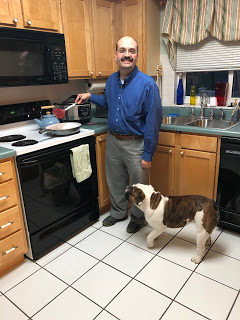

In [2]:
import urllib.request
import shutil
from IPython.display import Image
!mkdir /content/images/

URL = "https://github.com/jeffheaton/t81_558_deep_learning"
URL += "/raw/master/photos/jeff_cook.jpg"
LOCAL_IMG_FILE = "/content/images/jeff_cook.jpg"

with urllib.request.urlopen(URL) as response, \
  open(LOCAL_IMG_FILE, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

Image(filename=LOCAL_IMG_FILE)

### Installing YOLOv5

YOLO is not available directly through either PIP or CONDA.  Additionally, YOLO is not installed in Google CoLab by default. Therefore, whether you wish to use YOLO through CoLab or run it locally, you need to go through several steps to install it.  This section describes the process of installing YOLO.  The same steps apply to either CoLab or a local install.  For CoLab, you must repeat these steps each time the system restarts your virtual environment.  You must perform these steps only once for your virtual Python environment for a local install.  If you are installing locally, make sure to install to the same virtual environment you created for this course.  The following commands install YOLO directly from its GitHub repository.

In [3]:
!git clone https://github.com/ultralytics/yolov5
%cd /content/yolov5
%pip install -qr requirements.txt

from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v6.0-134-gc45f9f6 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.0/166.8 GB disk)


Next, we will run YOLO from the command line and classify the previously downloaded kitchen picture.  You can run this classification on any image you choose.

detect: weights=['yolov5s.pt'], source=/content/images/, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-134-gc45f9f6 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

100% 14.0M/14.0M [00:00<00:00, 108MB/s] 

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/images/jeff_cook.jpg: 640x480 1 person, 1 dog, 2 bottles, 1 bowl, 1 microwave, 2 ovens, 2 sinks, Done. (0.011s)
Speed: 0.5ms pre-process, 10.6ms inference, 33.8ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


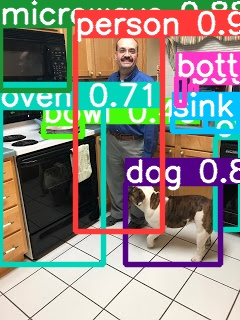

In [4]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source /content/images/
display.Image(filename='/content/yolov5/runs/detect/exp/jeff_cook.jpg', width=300)

### Running YOLOv5

In addition to the command line execution we just saw, the YOLO library can easily integrate with Python applications.  The following code adds the downloaded YOLOv5 to Python's environment, allowing **yolov5** to be imported like a regular Python library.

In [5]:
import sys
sys.path.append(str("/content/yolov5"))

from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v6.0-134-gc45f9f6 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.1/166.8 GB disk)


Next, we obtain an image to classify. For this example, the program loads the image from a URL.  YOLOv5 expects that the image is in the format of a Numpy array.  We use PIL to obtain this image.  We will convert it to the proper format for PyTorch and YOLOv5 later.

In [6]:
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms.functional as TF

url = "https://raw.githubusercontent.com/jeffheaton/"\
    "t81_558_deep_learning/master/images/cook.jpg"
response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
img = Image.open(BytesIO(response.content))

The following libraries are needed to classify this image.

In [7]:
import argparse
import os
import sys
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn

from models.common import DetectMultiBackend
from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync

We are now ready to load YOLO, with pretrained weights provided by the creators of YOLO.  It is also possible to train YOLO to recognize images of your own.

In [8]:
device = select_device('')
weights = '/content/yolov5/yolov5s.pt'
imgsz = [img.height, img.width]
original_size = imgsz
model = DetectMultiBackend(weights, device=device, dnn=False)
stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
imgsz = check_img_size(imgsz, s=stride)  # check image size
print(f"Original size: {original_size}")
print(f"YOLO input size: {imgsz}")

YOLOv5 🚀 v6.0-134-gc45f9f6 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients


Original size: [320, 240]
YOLO input size: [320, 256]


The creators of YOLOv5 built upon PyTorch, which has a particular format for images.  PyTorch images are generally a 4D matrix of the following dimensions:

* batch_size, channels, height, width

This code converts the previously loaded PIL image into this format.

In [9]:
import numpy as np
source = '/content/images/'

half = False
conf_thres=0.25  # confidence threshold
iou_thres=0.45  # NMS IOU threshold
classes = None
agnostic_nms=False,  # class-agnostic NMS
max_det=1000

model.warmup(imgsz=(1, 3, *imgsz), half=half)  # warmup
dt, seen = [0.0, 0.0, 0.0], 0

# https://stackoverflow.com/questions/50657449/convert-image-to-proper-dimension-pytorch
img2 = img.resize([imgsz[1],imgsz[0]], Image.ANTIALIAS)
    
img_raw = torch.from_numpy(np.asarray(img2)).to(device)
img_raw = img_raw.half() if half else img_raw.float()  # uint8 to fp16/32
img_raw /= 255  # 0 - 255 to 0.0 - 1.0
img_raw = img_raw.unsqueeze_(0)
img_raw = img_raw.permute(0, 3, 1, 2)
print(img_raw.shape)

   

torch.Size([1, 3, 320, 256])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)


With the image converted, we are now ready to present the image to YOLO and obtain predictions.

In [10]:
pred = model(img_raw, augment=False, visualize=False)
pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)


We now convert these raw predictions into the bounding boxes, labels, and confidences for each of the images that YOLO recognized.

In [11]:
results = []
for i, det in enumerate(pred):  # per image
  gn = torch.tensor(img_raw.shape)[[1, 0, 1, 0]]  

  if len(det):
      # Rescale boxes from img_size to im0 size
      det[:, :4] = scale_coords(original_size, det[:, :4], imgsz).round()

      # Write results
      for *xyxy, conf, cls in reversed(det):
        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()
        # Choose between xyxy and xywh as your desired format.
        results.append([names[int(cls)], float(conf), [*xyxy]])   

We can now see the results from the classification.

In [12]:
for itm in results:
  print(itm)

['bottle', 0.33485785126686096, [tensor(201., device='cuda:0'), tensor(70., device='cuda:0'), tensor(211., device='cuda:0'), tensor(101., device='cuda:0')]]
['oven', 0.3883479833602905, [tensor(243., device='cuda:0'), tensor(123., device='cuda:0'), tensor(256., device='cuda:0'), tensor(246., device='cuda:0')]]
['sink', 0.40188583731651306, [tensor(183., device='cuda:0'), tensor(107., device='cuda:0'), tensor(256., device='cuda:0'), tensor(129., device='cuda:0')]]
['oven', 0.8525269627571106, [tensor(0., device='cuda:0'), tensor(92., device='cuda:0'), tensor(117., device='cuda:0'), tensor(269., device='cuda:0')]]
['microwave', 0.8655257821083069, [tensor(0., device='cuda:0'), tensor(17., device='cuda:0'), tensor(80., device='cuda:0'), tensor(86., device='cuda:0')]]
['person', 0.8859685063362122, [tensor(88., device='cuda:0'), tensor(27., device='cuda:0'), tensor(185., device='cuda:0'), tensor(235., device='cuda:0')]]
['dog', 0.8902726173400879, [tensor(141., device='cuda:0'), tensor(181

It is important to note that the **yolo** class instantiated here is a callable object, which can fill the role of both an object and a function. Acting as a function, *yolo* returns three arrays named **boxes**, **scores**, and **classes** that are of the same length.  The function returns all sub-images found with a score above the minimum threshold.  Additionally, the **yolo** function returns an array named called **nums**. The first element of the **nums** array specifies how many sub-images YOLO found to be above the score threshold.

* **boxes** - The bounding boxes for each sub-image detected in the image sent to YOLO.
* **scores** - The confidence for each of the sub-images detected.
* **classes** - The string class names for each item.  These are COCO names such as "person" or "dog." 
* **nums** - The number of images above the threshold.

Your program should use these values to perform whatever actions you wish due to the input image.  The following code displays the images detected above the threshold.

To demonstrate the correctness of the results obtained, we draw bounding boxes over the original image.

[tensor(201., device='cuda:0'), tensor(70., device='cuda:0'), tensor(211., device='cuda:0'), tensor(101., device='cuda:0')]
[tensor(243., device='cuda:0'), tensor(123., device='cuda:0'), tensor(256., device='cuda:0'), tensor(246., device='cuda:0')]
[tensor(183., device='cuda:0'), tensor(107., device='cuda:0'), tensor(256., device='cuda:0'), tensor(129., device='cuda:0')]
[tensor(0., device='cuda:0'), tensor(92., device='cuda:0'), tensor(117., device='cuda:0'), tensor(269., device='cuda:0')]
[tensor(0., device='cuda:0'), tensor(17., device='cuda:0'), tensor(80., device='cuda:0'), tensor(86., device='cuda:0')]
[tensor(88., device='cuda:0'), tensor(27., device='cuda:0'), tensor(185., device='cuda:0'), tensor(235., device='cuda:0')]
[tensor(141., device='cuda:0'), tensor(181., device='cuda:0'), tensor(250., device='cuda:0'), tensor(267., device='cuda:0')]


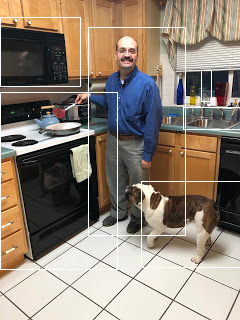

In [13]:
from PIL import Image, ImageDraw

img3 = img.copy()
draw = ImageDraw.Draw(img3)

for itm in results:
  b = itm[2]
  print(b)
  draw.rectangle(b)

img3

# Module 6 Assignment

You can find the first assignment here: [assignment 6](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class6.ipynb)